In [8]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

Cargar la base de datos del mnist

In [9]:
mnist = fetch_openml("mnist_784")
X, y = mnist.data, mnist.target.astype(int)

# Seleccion de solo imagenes de dígitos 0 y 1
#X = X[(y == 0) | (y == 1)]
#y = y[(y == 0) | (y == 1)]
# Convertir las etiquetas a codificación one-hot
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]


# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar datos
X_train = X_train / 255.0
X_test  = X_test  / 255.0

# dimensiones de los conjuntos
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(56000, 784) (56000,)
(14000, 784) (14000,)


Convertimos las etiquetas a One-hot y las imprimimos

In [10]:
#convertir las etiquetas a One-Hot
y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

# dimensiones de los conjuntos
print(X_train.shape, y_train_one_hot.shape)
print(X_test.shape, y_test_one_hot.shape)

(56000, 784) (56000, 10)
(14000, 784) (14000, 10)


Función de activación

In [11]:
def phi(x):
    return 1 / (1 + np.exp(-x))

Inicializar pesos y biases, aumentamos el tamaño del modelo en vez de 64 a 150 dado que ya son 10 clases, output=10 para 10 clases

In [12]:
input_size = X_train.shape[1]
hidden_size = 150
output_size = 10

#np.random.seed(0)  # descomentar si queremos replicar el entrenamiento
W_1 = 0.1*np.random.randn(input_size, hidden_size,)
b_1 = 0.1*np.zeros((1, hidden_size))
W_2 = 0.1*np.random.randn(hidden_size,output_size,)
b_2 = 0.1*np.zeros((1,output_size))

Parámetros de entrenamiento, agregamos los parámetros necesarios para AdamW estocástico

In [32]:
learning_rate = 1e-5
epochs = 50

beta1 = 0.9
beta2 = 0.99
epsilon = 1e-9

# Inicialización de momentos para AdamW
m_W1, m_b1, m_W2, m_b2 = np.zeros_like(W_1), np.zeros_like(b_1), np.zeros_like(W_2), np.zeros_like(b_2)
v_W1, v_b1, v_W2, v_b2 = np.zeros_like(W_1), np.zeros_like(b_1), np.zeros_like(W_2), np.zeros_like(b_2)


Ciclos de entrenamiento

In [33]:
#y_0 = X_train
#y   = np.expand_dims(y_train, axis=-1)

from sklearn.utils import shuffle #para mezclar aleatoriamente los datos

Losses=[]
for epoch in range(epochs):
    # Mezclar los datos (esto es el entrenamiento estocástico)
    X_train, y_train_one_hot = shuffle(X_train, y_train_one_hot)

    # Propagación hacia adelante
    z_1 = X_train @ W_1 + b_1
    y_1 = phi(z_1)
    z_2 = y_1 @ W_2 + b_2
    y_2 = phi(z_2)

    # Función de pérdida: entropía cruzada categórica
    loss = -np.mean(np.sum(y_train_one_hot * np.log(y_2 + epsilon) + (1 - y_train_one_hot) * np.log(1 - y_2 + epsilon), axis=1))

    # Backpropagation
    delta_2 = y_2 - y_train_one_hot
    delta_1 = np.dot(delta_2, W_2.T) * (y_1 * (1 - y_1))

    grad_W2 = np.dot(y_1.T, delta_2)
    grad_b2 = np.sum(np.array(delta_2), axis=0, keepdims=True)
    grad_W1 = np.dot(X_train.T, delta_1)
    grad_b1 = np.sum(np.array(delta_1), axis=0, keepdims=True)

    # Actualizar momentos (AdamW)
    m_W1 = beta1 * m_W1 + (1 - beta1) * grad_W1
    m_b1 = beta1 * m_b1 + (1 - beta1) * grad_b1
    m_W2 = beta1 * m_W2 + (1 - beta1) * grad_W2
    m_b2 = beta1 * m_b2 + (1 - beta1) * grad_b2

    v_W1 = beta2 * v_W1 + (1 - beta2) * grad_W1 ** 2
    v_b1 = beta2 * v_b1 + (1 - beta2) * grad_b1 ** 2
    v_W2 = beta2 * v_W2 + (1 - beta2) * grad_W2 ** 2
    v_b2 = beta2 * v_b2 + (1 - beta2) * grad_b2 ** 2

    # Corrección de sesgo para momentos
    m_W1_hat = m_W1 / (1 - beta1 ** (epoch + 1))
    m_b1_hat = m_b1 / (1 - beta1 ** (epoch + 1))
    m_W2_hat = m_W2 / (1 - beta1 ** (epoch + 1))
    m_b2_hat = m_b2 / (1 - beta1 ** (epoch + 1))

    v_W1_hat = v_W1 / (1 - beta2 ** (epoch + 1))
    v_b1_hat = v_b1 / (1 - beta2 ** (epoch + 1))
    v_W2_hat = v_W2 / (1 - beta2 ** (epoch + 1))
    v_b2_hat = v_b2 / (1 - beta2 ** (epoch + 1))

    # Actualización de parámetros (AdamW)
    W_1 -= learning_rate * m_W1_hat / (np.sqrt(v_W1_hat) + epsilon)
    b_1 -= learning_rate * m_b1_hat / (np.sqrt(v_b1_hat) + epsilon)
    W_2 -= learning_rate * m_W2_hat / (np.sqrt(v_W2_hat) + epsilon)
    b_2 -= learning_rate * m_b2_hat / (np.sqrt(v_b2_hat) + epsilon)

    # Reportar avance cada 1 época
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")
        Losses.append([epoch, loss])

Losses = np.array(Losses)

# Evaluación de precisión
z_1 = X_test @ W_1 + b_1
y_1 = phi(z_1)
z_2 = y_1 @ W_2 + b_2
y_2 = phi(z_2)

# Convierte las predicciones a clases
predictions = np.argmax(y_2, axis=1)  # Tomamos la clase con mayor probabilidad
y_test = np.array(y_test)

# Calcula Exactitud
accuracy = np.mean(predictions == y_test)
print(f"Exactitud de Prueba (Test accuracy): {accuracy}")

Epoch 0, Loss: 3.2256710394390304
Epoch 1, Loss: 3.224693269237879
Epoch 2, Loss: 3.2237171411090473
Epoch 3, Loss: 3.2227426780658273
Epoch 4, Loss: 3.2217699024073823
Epoch 5, Loss: 3.220798835706578
Epoch 6, Loss: 3.2198294988978575
Epoch 7, Loss: 3.2188619123101403
Epoch 8, Loss: 3.2178960956240465
Epoch 9, Loss: 3.2169320677654625
Epoch 10, Loss: 3.215969846813912
Epoch 11, Loss: 3.2150094499410806
Epoch 12, Loss: 3.2140508933734506
Epoch 13, Loss: 3.2130941923731005
Epoch 14, Loss: 3.2121393612302054
Epoch 15, Loss: 3.2111864132615784
Epoch 16, Loss: 3.2102353608138707
Epoch 17, Loss: 3.2092862152729524
Epoch 18, Loss: 3.2083389870800145
Epoch 19, Loss: 3.2073936857522525
Epoch 20, Loss: 3.2064503199046013
Epoch 21, Loss: 3.205508897269466
Epoch 22, Loss: 3.204569424713194
Epoch 23, Loss: 3.2036319082497875
Epoch 24, Loss: 3.2026963530535744
Epoch 25, Loss: 3.2017627634728503
Epoch 26, Loss: 3.200831143046102
Epoch 27, Loss: 3.199901494521737
Epoch 28, Loss: 3.198973819881547
Epo

Prueba

Text(0.5, 1.0, 'Evolución de la pérdida durante entrenamiento')

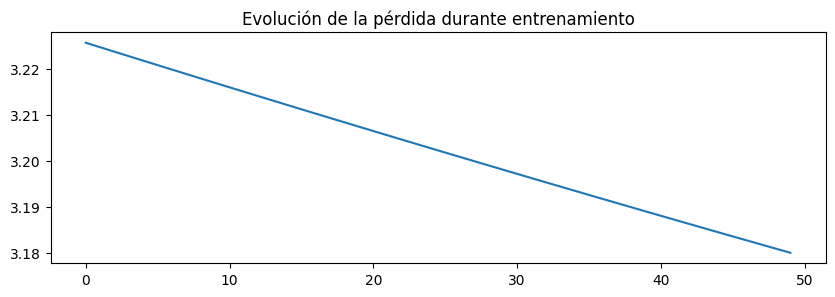

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(Losses[:,0],Losses[:,1])
plt.title('Evolución de la pérdida durante entrenamiento')

Para 10 clases es necesario un clasificador más robusto, pienso que la elección de usar como optimizador al AdamW fue de las mejores opciones de las qu hemos revisado anteriormente, por más que intenté ajustar parámetros no pude aumentar más el accuracy.